Copyright 2018 The TensorFlow Authors.

In [ ]:

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
     

#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 3_Image Classification with Convolutional Neural Networks

In this tutorial, we'll build and train a neural network to classify images of clothing, like sneakers and shirts. This guide uses tf.keras, a high-level API to build and train models in TensorFlow.

#### Introduction: CNNs

Convolutional Neural Networks (CNNs) are a specific type of artificial neural network architecture particularly well-suited for working with grid-like data, most commonly images. Their design is inspired by the structure and function of the animal visual cortex. Here's a breakdown of their purpose:

Main Purpose:

Extract features and patterns from grid-like data, primarily images and time series data. These features can then be used for various tasks like:
- Image classification (identifying objects or scenes in images)
- Object detection (locating specific objects within images)
- Image segmentation (classifying each pixel in an image)
- Time series forecasting (predicting future values in a sequence)

How They Work:

CNNs achieve their functionality through a series of convolutional layers followed by pooling layers and fully-connected layers:
- Convolutional layers: These layers apply learnable filters to the input data. The filters slide across the input, extracting features like edges, shapes, and textures. Each filter learns to detect a specific type of feature.
- Pooling layers: These layers downsample the output of convolutional layers, reducing the spatial dimensions (height and width) while retaining the most important information. This helps control overfitting and reduces computational cost. Common pooling types include average pooling and max pooling.
- Fully-connected layers: These layers operate similarly to traditional neural networks, connecting all neurons in one layer to all neurons in the next. They are typically used in the later stages for tasks like classification or regression.

Advantages of CNNs:

- Automatic feature extraction: Unlike traditional machine learning methods where features need to be hand-crafted, CNNs can automatically learn these features from the data.
- Efficient handling of spatial relationships: The convolutional layers effectively capture spatial relationships between pixels in images, crucial for tasks like object detection and image segmentation.
- Reduced data dimensionality: Pooling layers help reduce the dimensionality of the data, making it computationally more efficient and less prone to overfitting.

Applications of CNNs:

- Image recognition and classification: Identifying objects, faces, scenes, or activities in images. (e.g., self-driving cars, facial recognition software)
- Medical image analysis: Detecting abnormalities in X-rays, CT scans, or MRIs.
- Natural language processing: Processing sequential data like text, where the order of words matters. (e.g., sentiment analysis, machine translation)
- Time series forecasting: Predicting future values in time series data like stock prices or sensor readings.

#### Install and Import dependencies

In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Import the Fashion MNIST dataset

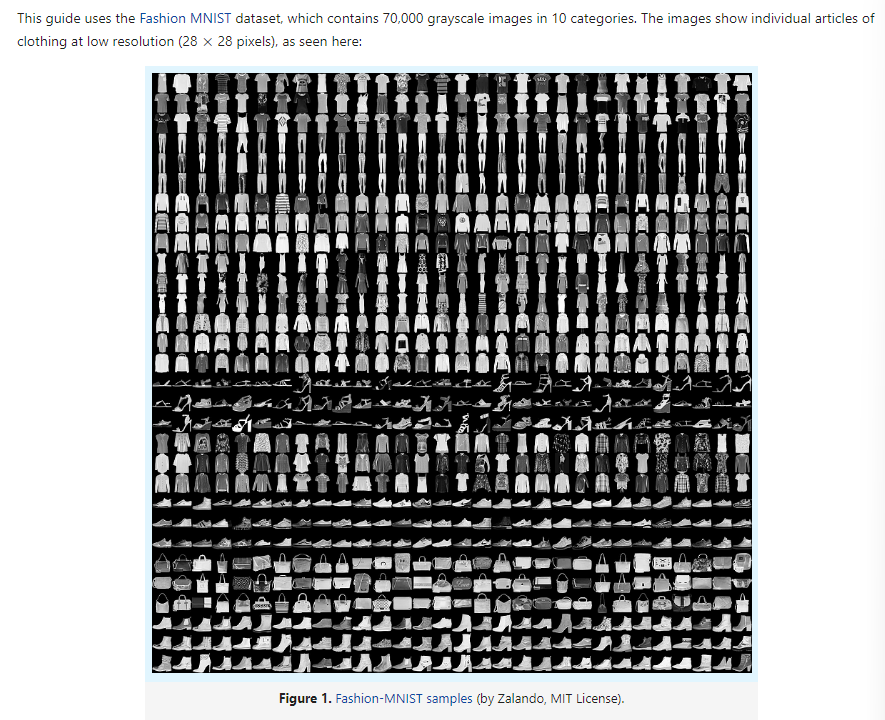

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow, using the Datasets API:

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

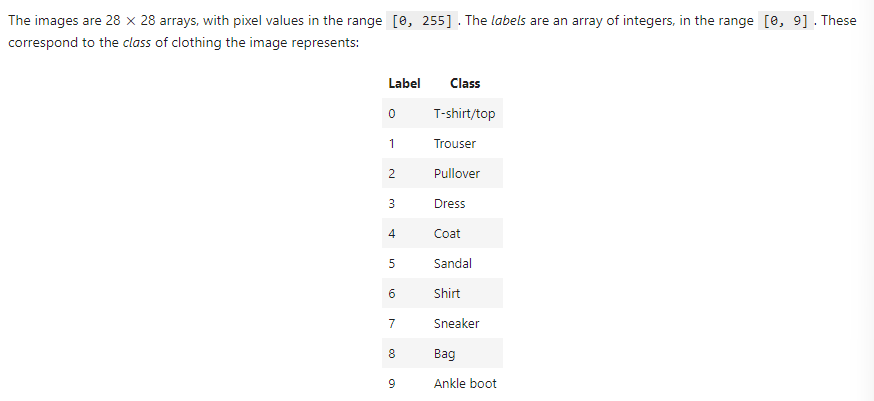

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

#### Explore the data
Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, and 10000 images in the test set:

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


#### Preprocess the data
The value of each pixel in the image data is an integer in the range [0,255]. For the model to work properly, these values need to be normalized to the range [0,1]. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [5]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

#### Explore the processed data
Let's plot an image to see what it looks like.

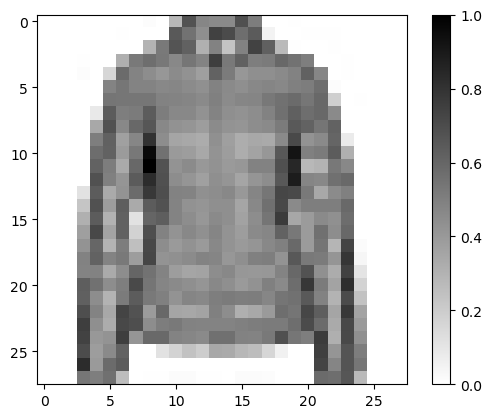

In [11]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

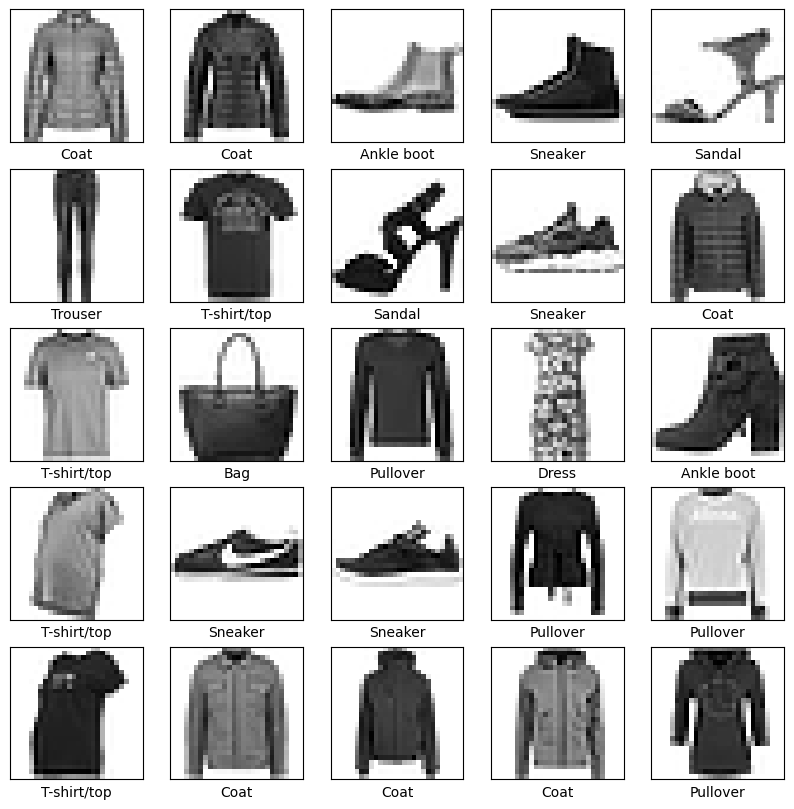

In [12]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

#### Build the model

##### Setup the layers

Deciding the ideal architecture for a CNN, including the number of layers, nodes (filters for convolutional layers), and other characteristics, is an iterative process that involves experimentation and often doesn't have a single "best" answer. Here are some key factors and approaches to consider:

Factors Affecting CNN Architecture:

- Problem complexity: Simpler tasks might require fewer layers and filters, while complex tasks like high-resolution image recognition might benefit from deeper architectures with more filters.
- Dataset size: Larger datasets can often support more complex models with more layers and filters without overfitting. Smaller datasets might require shallower networks or techniques like regularization to prevent overfitting.
- Computational resources: Training complex CNNs can be computationally expensive. Consider the available hardware and training time constraints when designing your model.

Approaches to Deciding Network Architecture:

1. Start Simple and Gradually Increase Complexity:

- Begin with a relatively simple architecture (e.g., fewer layers, filters). Train and evaluate the model's performance.
- Gradually increase the complexity (layers, filters) and re-train, monitoring validation performance to avoid overfitting.

2. Leverage Pre-trained Models (Transfer Learning):

- Utilize pre-trained models like VGG16 or ResNet that have been trained on massive datasets. These models can be fine-tuned for your specific task by replacing the final classification layers with your own, often requiring fewer layers and training time.

3. Use Grid Search or Random Search:

- These techniques involve systematically trying different combinations of hyperparameters (like number of layers, filters) and evaluating their performance. This can be computationally expensive but can help identify a good starting point.

4. Explore Existing Architectures:

- Look for research papers or open-source code related to your task. Existing architectures for similar problems can provide a good starting point for your model design.

General Guidelines (not strict rules):

- Number of Layers: Deeper architectures (more layers) can potentially learn more complex features. However, increasing depth can also lead to overfitting, especially with limited data.
- Number of Filters: More filters in a convolutional layer can potentially capture a wider range of features. However, too many filters can increase training time and complexity.
- Filter Size: Filter size controls the level of detail extracted. Smaller filters capture fine details, while larger filters capture broader features. Experiment with different sizes based on your task.
- Stride: Stride controls how much the filter moves across the input in each step. Larger strides can reduce the output size but might miss some information.

Additional Tips:

- Use Dropout Layers: These layers randomly drop a certain percentage of activations during training, helping prevent overfitting.
- Use Batch Normalization: This technique normalizes the activations of each layer, making the training process more stable.
- Monitor Validation Performance: Closely monitor the performance on a validation set to avoid overfitting the training data.

***Remember:*** The optimal architecture will depend on your specific task, dataset, and computational resources. Experimentation and evaluation are key to finding the best configuration for your CNN model.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Output layer with 10 class nodes
])

- ***"convolutions"*** tf.keras.layers.Conv2D and MaxPooling2D— Network start with two pairs of Conv/MaxPool. The first layer is a Conv2D filters (3,3) being applied to the input image, retaining the original image size by using padding, and creating 32 output (convoluted) images (so this layer creates 32 convoluted images of the same size as input). After that, the 32 outputs are reduced in size using a MaxPooling2D (2,2) with a stride of 2. The next Conv2D also has a (3,3) kernel, takes the 32 images as input and creates 64 outputs which are again reduced in size by a MaxPooling2D layer. So far in the course, we have described what a Convolution does, but we haven't yet covered how you chain multiples of these together. We will get back to this in lesson 4 when we use color images. At this point, it's enough if you understand the kind of operation a convolutional filter performs

- ***output*** tf.keras.layers.Dense — A 128-neuron, followed by 10-node softmax layer. Each node represents a class of clothing. As in the previous layer, the final layer takes input from the 128 nodes in the layer before it, and outputs a value in the range [0, 1], representing the probability that the image belongs to that class. The sum of all 10 node values is 1.

#### Compile the model

Choosing the right loss function and optimizer are crucial steps in building an effective CNN model. Here's a breakdown of factors to consider when making these decisions:

Loss Function:

- The loss function quantifies the difference between the model's predictions and the true labels. It guides the optimization process by indicating how much the model needs to improve.

Factors to Consider:

1. Task Type:

- Classification: If your task is to classify images into multiple categories (e.g., dog, cat), common loss functions include:
    - Categorical Cross-Entropy: Suitable for multi-class classification problems.
    - Binary Cross-Entropy: Used for binary classification (two classes).
- Regression: If your task involves predicting continuous values (e.g., image depth), consider:
    - Mean Squared Error (MSE): Measures the average squared difference between predictions and targets.
    - Mean Absolute Error (MAE): Measures the average absolute difference between predictions and targets, less sensitive to outliers.

2. Data Distribution:

- If your data has imbalanced classes (unequal distribution), consider using a weighted version of the chosen loss function to give more importance to the minority class.

Optimizers:

- The optimizer iteratively updates the model's weights and biases to minimize the loss function.

Factors to Consider:

1. Dataset Size:

- Large Datasets: Algorithms like Adam or RMSprop are popular choices for handling large datasets due to their efficient handling of gradients.
- Small Datasets: Stochastic Gradient Descent (SGD) with momentum or Adagrad might be suitable for smaller datasets.

2. Problem Complexity:

- Complex problems might benefit from optimizers like Adam or RMSprop that can adapt their learning rate based on the gradients encountered during training.

3. Learning Rate:

- Some optimizers require careful tuning of the learning rate, while others like Adam are more robust to learning rate choices.

Common Optimizers and their Characteristics:

- Stochastic Gradient Descent (SGD): A simple and versatile optimizer, but requires careful learning rate tuning.
- SGD with Momentum: Improves on SGD by considering the direction of previous updates, accelerating convergence.
- Adagrad: Adapts the learning rate for each parameter individually, useful for sparse data.
- RMSprop: Similar to Adagrad, but addresses its tendency to decrease learning rates too quickly.
- Adam: A popular choice for its efficiency and adaptability, often a good starting point.

General Tips:

- Start with a Common Combination: Begin with a frequently used combination like categorical cross-entropy loss and Adam optimizer.
- Evaluate Different Options: Experiment with different loss functions and optimizers suitable for your task and dataset. Monitor validation performance to avoid overfitting.
- Learning Rate Tuning: Even with adaptive optimizers, fine-tuning the learning rate can sometimes improve performance. Use techniques like learning rate scheduling to adjust the learning rate during training.
- Early Stopping: Implement early stopping to prevent overfitting. This technique stops training when the validation loss plateaus or starts to increase.

By considering these factors and experimenting with different options, you can find the most suitable loss function and optimizer for your specific CNN model. Remember, there's no single "best" combination, and the optimal choice will depend on your task, dataset, and computational resources.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Common Metrics for CNNs:

- The choice of metrics depends on the specific task your CNN is designed for:

Classification Tasks:

- Accuracy: The percentage of predictions that are correct. A common metric, but can be misleading for imbalanced datasets.
- Precision: Measures the proportion of positive predictions that are actually correct. Useful for identifying how many of the model's positive predictions are true positives.
- Recall: Measures the proportion of actual positive cases that are correctly identified by the model. Useful for identifying how well the model finds all positive cases.
- F1-Score: A harmonic mean of precision and recall, combining their strengths into a single metric.

Regression Tasks:

- Mean Squared Error (MSE): Measures the average squared difference between predictions and targets.
- Mean Absolute Error (MAE): Measures the average absolute difference between predictions and targets, less sensitive to outliers.

Using Metrics:

- Evaluation: Metrics are typically used on a held-out validation set or test set to assess the model's performance on unseen data.
- Monitoring Training: Metrics can also be monitored during training to identify potential issues like overfitting.
- Comparison: Metrics allow you to compare the performance of different models trained on the same task.

Choosing Metrics:

- The choice of metrics depends on the task and the business goals. Here are some additional factors to consider:

- Imbalanced Classes: If your data has imbalanced classes, accuracy might not be the best metric. Consider using precision, recall, or F1-score.
- Cost of Errors: If certain types of errors are more costly than others, choose metrics that reflect that cost. For example, in medical diagnosis, a false negative (missing a disease) might be more critical than a false positive.

Additional Tips:

- Use a Combination of Metrics: Don't rely on a single metric. Use a combination of metrics relevant to your task to get a more comprehensive picture of performance.
- Visualize Performance: Consider using visualizations like confusion matrices or ROC curves to understand how the model performs on different classes.

By incorporating metrics into your CNN development process, you can gain valuable insights into your model's effectiveness and make informed decisions about its training and deployment.

#### Train the model
First, we define the iteration behavior for the train dataset:

- Repeat forever by specifying dataset.repeat() (the epochs parameter described below limits how long we perform training).
- The dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
- And dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the model.fit method:

- Feed the training data to the model using train_dataset.
- The model learns to associate images and labels.
- The epochs=5 parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3930 - accuracy: 0.8577
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2565 - accuracy: 0.9063
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2120 - accuracy: 0.9211
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1815 - accuracy: 0.9332
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1540 - accuracy: 0.9424
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1313 - accuracy: 0.9513
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1111 - accuracy: 0.9580
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0934 - accuracy: 0.9649
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0797 - accuracy: 0.9708
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.065

#### Evaluate accuracy
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.2943 - accuracy: 0.9202
Accuracy on test dataset: 0.920199990272522


#### Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [18]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 81ms/step


In [19]:
predictions.shape

(32, 10)

In [20]:
#1st prediction
predictions[0]

array([2.7406440e-08, 2.0791997e-06, 1.1263558e-03, 9.8111051e-12,
       9.9785763e-01, 3.2401956e-11, 1.0137247e-03, 5.2814706e-12,
       4.1886306e-08, 7.2586048e-09], dtype=float32)

In [21]:
np.argmax(predictions[0])

4

In [22]:
test_labels[0] #matches

4

In [23]:
class_names[4]

'Coat'

We can graph this to look at the full set of 10 class predictions

In [24]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

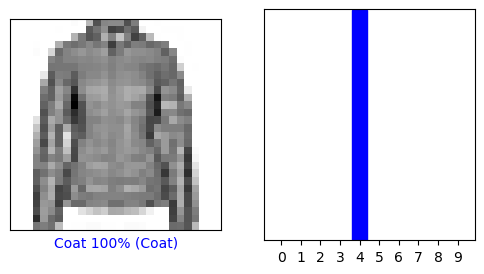

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

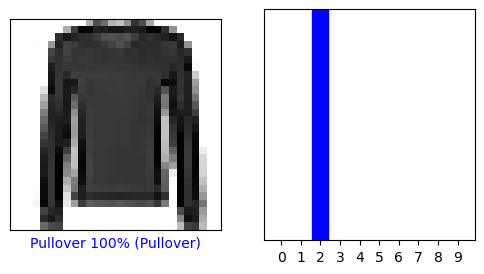

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

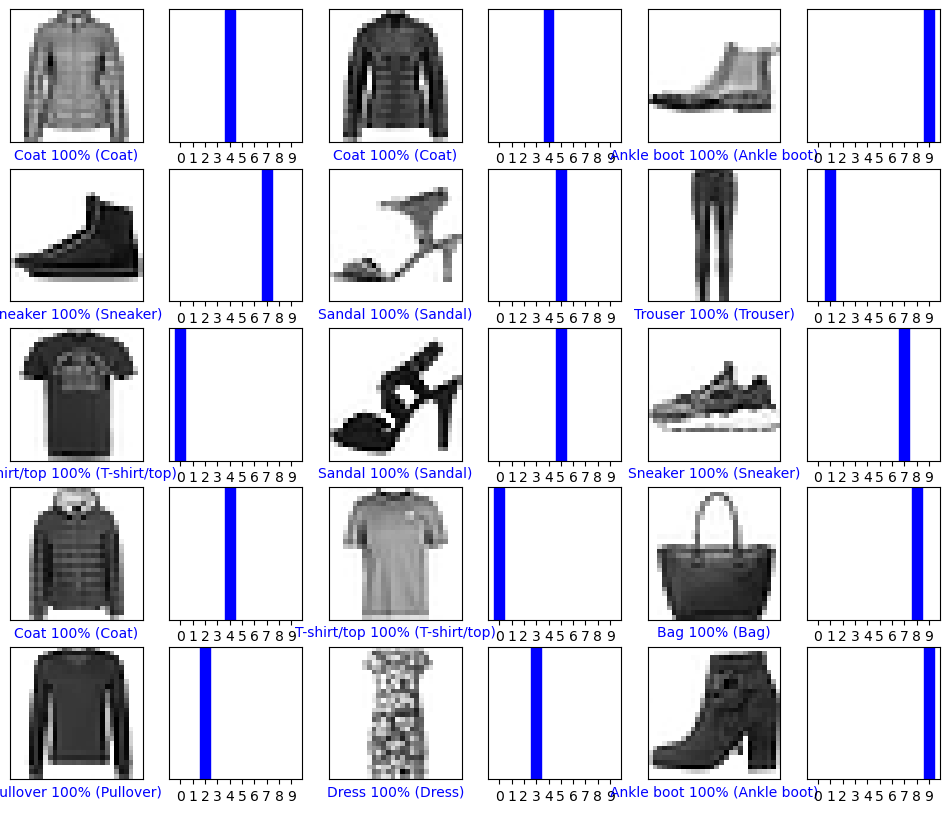

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Finally, use the trained model to make a prediction about a single image.

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [29]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [30]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 67ms/step
[[2.7406440e-08 2.0792017e-06 1.1263558e-03 9.8111241e-12 9.9785763e-01
  3.2401956e-11 1.0137247e-03 5.2814805e-12 4.1886306e-08 7.2586048e-09]]


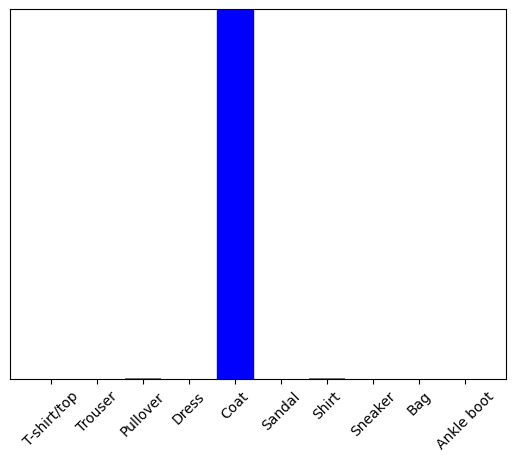

In [31]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [36]:
class_names[np.argmax(predictions_single[0])]

'Coat'